# Ozone Transformer Example

## Environments Setup

1. Create Python virtual environment named `venv`
   - `python -m venv venv`
2. Activate the new virtual environment `venv`
   - `source venv/bin/activate`
3. Install required python libraries from `ot_requirements.txt` file
   - `pip install -r ot_requirements.txt`
4. Select `venv` as python kernel for this JupyterNotebook

In [1]:
import functools
import time

from tqdm import tqdm

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset


## Prepare Dataset

In [2]:
xr_ot = xr.open_dataset("data/mljc_workshop_o3_L25.nc")

In [3]:
ozone_arr = xr_ot["SpeciesConcVV_O3"].data
ozone_arr_trimmed = ozone_arr[:, :-2, :]

In [4]:
ozone_chunked = ozone_arr_trimmed.reshape(
    ozone_arr_trimmed.shape[0], 
    ozone_arr_trimmed.shape[1] // 11, 11, 
    ozone_arr_trimmed.shape[2] // 12, 12
).swapaxes(2, 3).swapaxes(0, 2)
ozone_chunked = ozone_chunked.reshape(-1, *ozone_chunked.shape[2:])

In [5]:
ozone_chunked_trimmed = ozone_chunked[:, :-20, :, :]

In [6]:
ozone_chunked = ozone_chunked_trimmed.reshape(
    ozone_chunked_trimmed.shape[0], 
    ozone_chunked_trimmed.shape[1] // 100, 100, 
    ozone_chunked_trimmed.shape[2], 
    ozone_chunked_trimmed.shape[3]
)
ozone_chunked = ozone_chunked.reshape(-1, *ozone_chunked.shape[2:])

In [7]:
ozone_chunked = ozone_chunked.reshape(*ozone_chunked.shape[:-2], -1)

In [8]:
MAP_SHAPE = (11, 12)

In [9]:
# ozone_chunked = ozone_chunked[:100]

In [10]:
ozone_chunked.shape

(696, 100, 132)

In [11]:
def shift_tensor_right(x, shift, dim):
    size = x.size(dim)
    if shift >= size:
        # Entire tensor becomes zero
        return torch.zeros_like(x)

    # Slice from start to size - shift along dim
    sliced = x.narrow(dim, 0, size - shift)

    # Pad with zeros at the beginning along that dimension
    pad_shape = list(x.shape)
    pad_shape[dim] = shift
    pad_tensor = torch.zeros(pad_shape, dtype=x.dtype, device=x.device)

    return torch.cat((pad_tensor, sliced), dim=dim)

shift_sequence_dim_right = functools.partial(shift_tensor_right, shift=1, dim=1)


The dimension of the dataset: (batch_size, sequence_size, embedding_size)

We have following dataset:
- input: `ozone_chunked`
- output: `ozone_chunked_shifted`

In [12]:
SRC_train, SRC_test = train_test_split(ozone_chunked, train_size=0.8)

In [13]:
SRC_train = torch.tensor(SRC_train)
SRC_test  = torch.tensor(SRC_test)

In [14]:
TGT_train = shift_sequence_dim_right(SRC_train)
TGT_test = shift_sequence_dim_right(SRC_test)

Divided into train and test dataset (let's ignore validation datasets)
- Train:
    - `SRC_train`
    - `TGT_train`
- Test:
    - `SRC_test`
    - `TGT_test`

In [15]:
dataset_train = TensorDataset(SRC_train, TGT_train)
dataset_test = TensorDataset(SRC_test, TGT_test)

dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=16, shuffle=True)

## Model Setup

In [16]:
def get_sinusoidal_positional_embedding(sequence_size, embedding_size):
    pos = torch.arange(0, sequence_size, dtype=torch.float).unsqueeze(1)
    i = torch.arange(0, embedding_size, 2).float()
    angle_rates = 1 / (10000 ** (i / embedding_size))
    
    angle_rads = pos * angle_rates  # [seq_len, d_model/2]

    pe = torch.zeros(sequence_size, embedding_size)
    pe[:, 0::2] = torch.sin(angle_rads)
    pe[:, 1::2] = torch.cos(angle_rads)

    return pe  # [seq_len, d_model]

In [17]:
EMBEDDING_SIZE = SRC_test.shape[2]
SEQUENCE_SIZE = SRC_train.shape[1]

In [18]:
class TransformerModel(torch.nn.Module):
    def __init__(
            self, 
            embedding_size, 
            n_head, n_encoder_layer, n_decoder_layer, n_feedforward, 
            positional_embedding_func,
            sequence_dim_shift_func,
        ):
        super(TransformerModel, self).__init__()

        self.positional_encoding_func = positional_embedding_func
        self.sequence_dim_shift_func = sequence_dim_shift_func

        self.transformer = torch.nn.Transformer(
            embedding_size, 
            n_head, 
            n_encoder_layer, 
            n_decoder_layer, 
            n_feedforward, 
            batch_first=True
        )
        
    def forward(self, x):
        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(x.shape[1])
        
        x += self.positional_encoding_func(x.shape[1], x.shape[2])
        x_shifted = self.sequence_dim_shift_func(x)
        x = self.transformer(x, x_shifted, tgt_mask=tgt_mask)

        return x

## Training

**Logging Setups**

In [ ]:
num_epochs = 50
train_losses = np.zeros(num_epochs)
train_accuracies = np.zeros(num_epochs)

test_losses = np.zeros(num_epochs)
test_accuracies = np.zeros(num_epochs)

**Model Setups**

In [ ]:
device = torch.device("cpu")
model = TransformerModel(EMBEDDING_SIZE, 12, 4, 4, 1024, get_sinusoidal_positional_embedding, shift_sequence_dim_right)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
print(model.parameters)

<bound method Module.parameters of TransformerModel(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=132, out_features=132, bias=True)
          )
          (linear1): Linear(in_features=132, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=132, bias=True)
          (norm1): LayerNorm((132,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((132,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((132,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
   

In [22]:
def train_epoch(model, train_loader, loss_fn, optimizer):
    global device

    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    # total_batches = 0
    total_batches = len(train_loader)
    
    for ozone_seq, ozone_seq_shifted in tqdm(train_loader, "Training"):
        
        ozone_seq, ozone_seq_shifted = ozone_seq.to(device), ozone_seq_shifted.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(ozone_seq)
        
        # Compute loss and gradients
        loss = loss_fn(outputs, ozone_seq_shifted)
        loss.backward()
        
        # Update model parameters
        optimizer.step()
        
        # Calculate accuracy
        accuracy = loss.item()
        
        epoch_loss += loss.item()
        epoch_accuracy += accuracy
    
    return epoch_loss / total_batches, epoch_accuracy / total_batches

def evaluate(model, test_loader, loss_fn):
    global device
    
    model.eval()
    epoch_loss = 0
    epoch_accuracy = 0
    total_batches = len(test_loader)
    
    with torch.no_grad():
        for texts, labels in tqdm(test_loader, "Evaluating"):
            texts, labels = texts.to(device), labels.to(device)
            # Forward pass
            outputs = model(texts)
            
            # Compute loss
            loss = loss_fn(outputs, labels)
            
            # Calculate accuracy
            accuracy = loss.item()
            
            epoch_loss += loss.item()
            epoch_accuracy += accuracy
    
    return epoch_loss / total_batches, epoch_accuracy / total_batches

In [23]:
for epoch in range(num_epochs):
    start_time = time.time()
    
    # Train for one epoch
    train_loss, train_accuracy = train_epoch(model, dataloader_train, loss_fn, optimizer)
    train_losses[epoch] = train_loss
    train_accuracies[epoch] = train_accuracy
    
    # Evaluate on the test set
    test_loss, test_accuracy = evaluate(model, dataloader_test, loss_fn)
    test_losses[epoch] = test_loss
    test_accuracies[epoch] = test_accuracy
    end_time = time.time()
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Time: {end_time - start_time:.2f}s")
    print(f"Train Loss: {train_loss:.4f} \t| Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}   \t| Test Accuracy: {test_accuracy:.4f}")

Evaluating: 100%|██████████| 9/9 [00:01<00:00,  4.95it/s]


Epoch [1/5] | Time: 26.91s
Train Loss: 0.9380 	| Train Accuracy: 0.9380
Test Loss: 0.8713   	| Test Accuracy: 0.8713


Evaluating: 100%|██████████| 9/9 [00:02<00:00,  4.30it/s]


Epoch [2/5] | Time: 25.93s
Train Loss: 0.8126 	| Train Accuracy: 0.8126
Test Loss: 0.7508   	| Test Accuracy: 0.7508


Evaluating: 100%|██████████| 9/9 [00:02<00:00,  4.30it/s]


Epoch [3/5] | Time: 25.57s
Train Loss: 0.6967 	| Train Accuracy: 0.6967
Test Loss: 0.6389   	| Test Accuracy: 0.6389


Evaluating: 100%|██████████| 9/9 [00:02<00:00,  4.29it/s]


Epoch [4/5] | Time: 28.23s
Train Loss: 0.5858 	| Train Accuracy: 0.5858
Test Loss: 0.5288   	| Test Accuracy: 0.5288


Evaluating: 100%|██████████| 9/9 [00:01<00:00,  4.79it/s]

Epoch [5/5] | Time: 29.28s
Train Loss: 0.4784 	| Train Accuracy: 0.4784
Test Loss: 0.4256   	| Test Accuracy: 0.4256


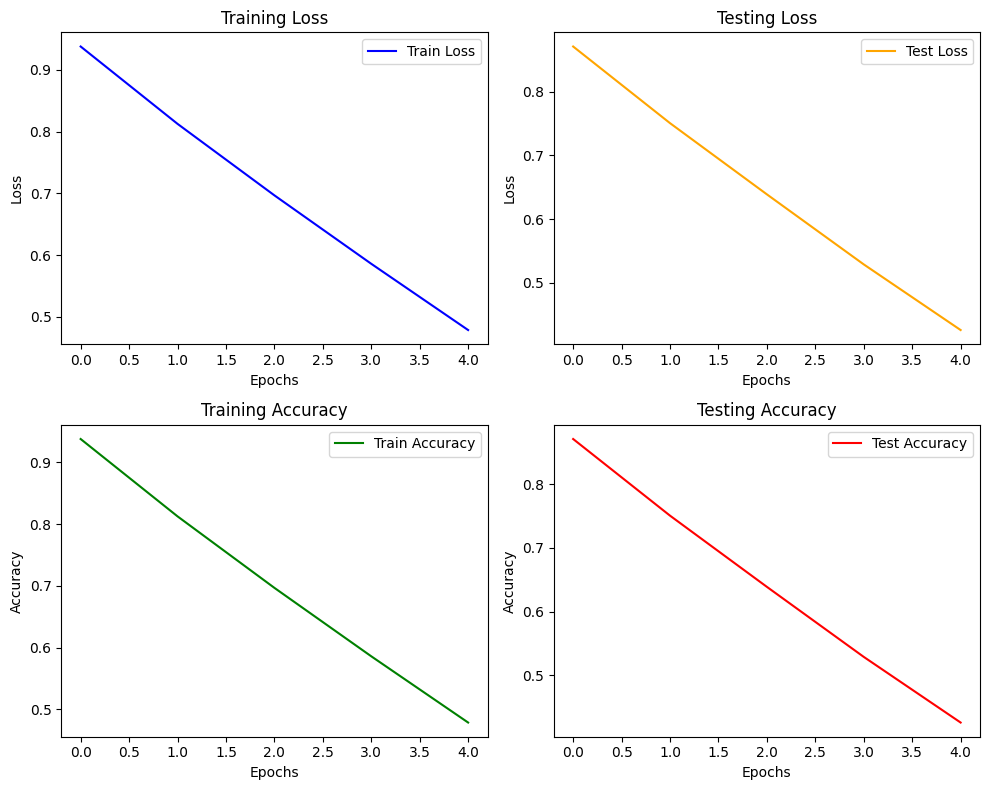

In [24]:
epochs = list(range(0, num_epochs))

# Create 2x2 grid of subplots using plt.subplot
plt.figure(figsize=(10, 8))

# Training Loss
plt.subplot(2, 2, 1)  # (rows, columns, index)
plt.plot(epochs, train_losses, color='blue', label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Testing Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, test_losses, color='orange', label='Test Loss')
plt.title('Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, train_accuracies, color='green', label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Testing Accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, test_accuracies, color='red', label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

In [25]:
torch.save(model.state_dict(), "trained_model/ot.pth")

In [29]:
model(SRC_test[:1])

tensor([[[ 0.2289, -0.1608,  0.1306,  ..., -0.3564, -0.2204, -0.3163],
         [ 0.2289, -0.1607,  0.1306,  ..., -0.3563, -0.2205, -0.3164],
         [ 0.2289, -0.1607,  0.1307,  ..., -0.3563, -0.2205, -0.3164],
         ...,
         [ 0.2292, -0.1603,  0.1306,  ..., -0.3558, -0.2205, -0.3167],
         [ 0.2292, -0.1604,  0.1305,  ..., -0.3558, -0.2205, -0.3167],
         [ 0.2292, -0.1604,  0.1305,  ..., -0.3558, -0.2205, -0.3167]]],
       grad_fn=<NativeLayerNormBackward0>)